<!DOCTYPE html>
<html>
<head>
<style>
    .header-banner {
        background-color: white;
        color: black; 
        padding: 1rem; 
        font-family: 'Nunito', sans-serif;
    }
    .header-content {
        max-width: 2000px;
        margin: 0 auto;
        display: flex;
        align-items: center;
        gap: 2rem;
    }
    .logo {
        max-width: 160px;
    }
    .text-content {
        flex: 1;
    }
    .text-content h1 {
        font-size: 34px;
        margin: 0 0 10px;
        font-weight: 700;
        color: #7e4d02ff;
        border-bottom: 2px solid #e5c120ff;
        padding-bottom: 10px;
    }
    .text-content h2 {
        font-size: 21px;
        margin: 0 0 5px;
        font-weight: 600;
        color: #222;
    }
    .member-list {
        display: grid;
        grid-template-columns: repeat(2, auto);
        gap: 6px 40px;
        font-size: 17px;
        color: #444;
    }
    .member {
        position: relative;
        padding-left: 20px;
    }
</style>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Nunito:wght@400;700&display=swap" rel="stylesheet">
</head>
<body>

<header class="header-banner">
    <div class="header-content">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" alt="NOVA IMS Logo" class="logo">
        <div class="text-content">
            <h1>Cars 4 You: Expediting Car Evaluations with ML</h1>
            <h2>Group 37 - Part 2: Regression Benchmarking & Optimization</h2>
            <div class="member-list">
                <div class="member">Filipa Pereira, 20240509</div>
                <div class="member">Gonçalo Silva, 20250354</div>
                <div class="member">Marta La Feria, 20211051 </div>
                <div class="member">Tomás Coroa, 20250394 </div>
            </div>
        </div>
    </div>
</header>

</body>
</html>

---
## Table of Contents

1. [Setup & Data Loading](#1-setup)
2. [Feature Selection](#2-feature-selection)
3. [Regression Benchmarking](#3-benchmarking)
4. [Model Optimization - Ensemble & Stacking](#4-optimization)
5. [Deployment - Final Submission](#5-deployment)


---

<a id='1-setup'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>1 | Setup & Data Loading</b></span>
    </h1>
</div>

### 1.1 Import Libraries

In [1]:
# Standard library
from itertools import combinations

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import ttest_ind, chi2_contingency, f_oneway

# Sklearn - Base
from sklearn.base import clone
from sklearn.model_selection import ParameterGrid

# Sklearn - Feature Selection
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_regression

# Sklearn - Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, 
    ExtraTreesRegressor, 
    GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Sklearn - Metrics
from sklearn.metrics import (
    mean_absolute_error, 
    root_mean_squared_error, 
    mean_pinball_loss, 
    make_scorer
)

# Custom utilities
import utils

# MLxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


# Plot style
palette = ['#5C4212','#a92f02', '#a55b1bf9', '#b08972', '#e3a76c', '#e5c120','#f39c06','#f2e209']

### 1.2 Load Data

In [2]:
# Load dictionary for brand/model cleaning
brand_model_dic = pd.read_parquet("./project_data/brand_model_dic.parquet", engine="pyarrow")

# Load the datasets (train, validation, test)
X_train_scaled = pd.read_parquet("./project_data/X_train_scaled.parquet", engine="pyarrow")
X_val_scaled   = pd.read_parquet("./project_data/X_val_scaled.parquet",   engine="pyarrow")
X_test_scaled  = pd.read_parquet("./project_data/X_test_scaled.parquet",  engine="pyarrow")

y_train = pd.read_parquet("./project_data/y_train.parquet", engine="pyarrow").squeeze("columns")
y_val   = pd.read_parquet("./project_data/y_val.parquet",   engine="pyarrow").squeeze("columns")

# Set carID as index
X_train_scaled, X_val_scaled, X_test_scaled = [d.set_index('carID') for d in (X_train_scaled, X_val_scaled, X_test_scaled)]
y_train, y_val = [d.set_index('carID') for d in (y_train, y_val)]

print(f"Train: {X_train_scaled.shape[0]:,} rows, {X_train_scaled.shape[1]} features")
print(f"Val:   {X_val_scaled.shape[0]:,} rows")
print(f"Test:  {X_test_scaled.shape[0]:,} rows")

Train: 60,768 rows, 37 features
Val:   15,193 rows
Test:  32,567 rows


In [3]:
# Prepare target arrays and combined datasets
all_features = list(X_train_scaled.columns)

# Target arrays
y_train_array = y_train['price'].values if isinstance(y_train, pd.DataFrame) else y_train.values.ravel()
y_val_array   = y_val['price'].values if isinstance(y_val, pd.DataFrame) else y_val.values.ravel()

# Log transformation of target (reduces impact of outliers)
y_train_log = np.log1p(y_train_array)
y_val_log   = np.log1p(y_val_array)

# Combined train+val for final model training
X_train_full_scaled   = pd.concat([X_train_scaled, X_val_scaled], axis=0)
y_train_full_array    = np.concatenate([y_train_array, y_val_array])
y_train_full_log      = np.concatenate([y_train_log, y_val_log])

print(f"Train samples: {len(y_train_array):,}")
print(f"Val samples:   {len(y_val_array):,}")
print(f"Full samples:  {len(y_train_full_array):,}")

Train samples: 60,768
Val samples:   15,193
Full samples:  75,961


<a id='2-feature-selection'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>2 | Feature Selection</b></span>
    </h1>
</div>

### 2.1 Business Based

In [4]:
X_train_scaled = X_train_scaled.drop(columns='paintQuality%', errors='ignore')
X_val_scaled =X_val_scaled.drop(columns='paintQuality%', errors='ignore')
X_test_scaled = X_test_scaled.drop(columns='paintQuality%', errors='ignore')

### 2.2 Variance Threshold

In [5]:
# Get rid of variables with variance close to zero (<= 0.01)
vart = VarianceThreshold(threshold=0.01)

#fit
X_train_sel = vart.fit(X_train_scaled)

# Get low variance columns and print them
low_variance = X_train_scaled.columns[vart.variances_ <= 0.01]
print("Number of features with variance closer to zero:", len(low_variance))
print("Features with variance closer to zero:")
for col in low_variance:
    print(f"{col}: {vart.variances_[X_train_scaled.columns.get_loc(col)]:.4f}")

# Drop low variance columns from train, val and test sets
X_train_scaled = X_train_scaled.drop(columns=low_variance, errors='ignore')
X_val_scaled = X_val_scaled.drop(columns=low_variance, errors='ignore')
X_test_scaled = X_test_scaled.drop(columns=low_variance, errors='ignore')

Number of features with variance closer to zero: 4
Features with variance closer to zero:
hasDamage: 0.0000
transmission_other: 0.0000
fuelType_electric: 0.0001
fuelType_other: 0.0022


### 2.3 Correlation Indices with price

In [6]:
# Correlação de cada feature com o target (price)
cor_with_target = pd.concat([
    X_train_scaled, 
    pd.Series(y_train_log, index=X_train_scaled.index, name='price')
], axis=1).corr(method='spearman')['price'].drop('price')

# Criar DataFrame ordenado por valor absoluto
cor_df = pd.DataFrame({
    'Feature': cor_with_target.index,
    'Correlation': cor_with_target.values,
    'Abs_Correlation': np.abs(cor_with_target.values)
}).sort_values('Abs_Correlation', ascending=False).reset_index(drop=True)

# Mostrar
print("=== Correlation with Price (Spearman) ===")
display(cor_df)

# Destacar features com baixa correlação (|corr| < 0.1)
low_corr = cor_df[cor_df['Abs_Correlation'] < 0.1]
print(f"\ Features with |corr| < 0.1 ({len(low_corr)}):")
display(low_corr)

<>:20: SyntaxWarning: invalid escape sequence '\ '
<>:20: SyntaxWarning: invalid escape sequence '\ '
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_20936\3694254821.py:20: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ Features with |corr| < 0.1 ({len(low_corr)}):")


=== Correlation with Price (Spearman) ===


,Feature,Correlation,Abs_Correlation
0,model_mean_price,0.765409,0.765409
1,mpg_per_liter,-0.598963,0.598963
2,age,-0.595517,0.595517
3,age_squared,-0.595517,0.595517
4,brand_mean_price,0.579865,0.579865
5,transmission_manual,-0.579796,0.579796
6,age_mileage_interaction,-0.570180,0.570180
7,engineSize,0.562210,0.562210
8,brand_price_std,0.547267,0.547267
9,premium_brand_engine_size_interaction,0.546488,0.546488


\ Features with |corr| < 0.1 (11):


,Feature,Correlation,Abs_Correlation
22,fuelType_hybrid,0.073977,0.073977
23,mpg_is_missing,0.051705,0.051705
24,tax_is_missing,0.050216,0.050216
25,brand_segment_mid_range,-0.048382,0.048382
26,tax_per_engine,-0.037308,0.037308
27,brand_popularity,-0.015392,0.015392
28,engineSize_is_missing,-0.004615,0.004615
29,year_is_missing,0.003744,0.003744
30,transmission_unknown,0.002575,0.002575
31,fuelType_unknown,0.001427,0.001427


In [7]:
drop_features = ['mpg_is_missing', 'tax_is_missing', 'engineSize_is_missing', 'year_is_missing', 
                 'transmission_unknown', 'fuelType_unknown']

for df in [X_train_scaled, X_val_scaled, X_test_scaled]:
    df.drop(columns=drop_features, inplace=True, errors='ignore')

### 2.4 Statistical Hypothesis Testing - ANOVA

In [8]:
from sklearn.feature_selection import f_regression

bin_cols = [c for c in X_train_scaled.columns if X_train_scaled[c].dropna().nunique() == 2]

X_train_cat = X_train_scaled.copy()
for c in bin_cols:
    X_train_cat[c] = X_train_scaled[c].astype('category')

alpha = 0.01

COLS = X_train_cat.columns.tolist()

# Prepare data - handle missing values
X_anova = X_train_cat[COLS].copy()
y_price = y_train_log.copy()  # It's already the price values

# Remove rows with NaN in either X or y
mask = ~(X_anova.isna().any(axis=1) | np.isnan(y_price))
X_anova_clean = X_anova[mask]
y_price_clean = y_price[mask]

# Run f_regression (sklearn's F-test for regression)
f_stats, p_values = f_regression(X_anova_clean, y_price_clean)

# Build results DataFrame
anova_results = []
for i, col in enumerate(COLS):
    decision = "predictive" if p_values[i] < alpha else "NOT predictive"
    anova_results.append({
        "Variable": col,
        "Test": "f_regression",
        "F_Stat": f_stats[i],
        "p_value": p_values[i],
        "Decision": decision
    })

df_anova = pd.DataFrame(anova_results).sort_values('p_value', na_position='last').reset_index(drop=True)
pd.set_option('display.max_rows', None)
display(df_anova)
pd.reset_option('display.max_rows')

,Variable,Test,F_Stat,p_value,Decision
0,mileage,f_regression,23440.674559,0.000000e+00,predictive
1,tax,f_regression,7843.008120,0.000000e+00,predictive
2,mpg,f_regression,7512.339124,0.000000e+00,predictive
3,engineSize,f_regression,23766.720475,0.000000e+00,predictive
4,brand_price_std,f_regression,26033.787419,0.000000e+00,predictive
5,age_mileage_interaction,f_regression,34079.885409,0.000000e+00,predictive
6,miles_per_year,f_regression,5934.060893,0.000000e+00,predictive
7,age,f_regression,37785.238260,0.000000e+00,predictive
8,mpg_per_liter,f_regression,25084.478115,0.000000e+00,predictive
9,brand_mean_price,f_regression,28060.117397,0.000000e+00,predictive


In [ ]:
drop_features = ['previousOwners']

for df in [X_train_scaled, X_val_scaled, X_test_scaled]:
    df.drop(columns=drop_features, inplace=True, errors='ignore')

### 2.2 Calculate Feature Importance per Model

In [14]:
# Lasso Regularization (L1) 
lasso_model = Lasso(alpha=1.0, random_state=37, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train_array)
lasso_coefs = pd.Series(lasso_model.coef_, index=X_train_scaled.columns)
lasso_importance = lasso_coefs.abs().sort_values(ascending=False)

# Ridge Regularization (L2) 
ridge_model = Ridge(alpha=1.0, random_state=37)
ridge_model.fit(X_train_scaled, y_train_array)
ridge_coefs = pd.Series(ridge_model.coef_, index=X_train_scaled.columns)
ridge_importance = ridge_coefs.abs().sort_values(ascending=False)

# ElasticNet Regularization (L1 + L2)
elasticnet_model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=37, max_iter=10000)
elasticnet_model.fit(X_train_scaled, y_train_array)
elasticnet_coefs = pd.Series(elasticnet_model.coef_, index=X_train_scaled.columns)
elasticnet_importance = elasticnet_coefs.abs().sort_values(ascending=False)

# GB - Native Feature Importance
gb_base = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=37)
gb_base.fit(X_train_scaled, y_train_array)
gb_importance = pd.Series(gb_base.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# RF - Native Feature Importance
rf_base = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=37, n_jobs=-1)
rf_base.fit(X_train_scaled, y_train_array)
rf_importance = pd.Series(rf_base.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# ExtraTrees - Native Feature Importance
et_base = ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=37, n_jobs=-1)
et_base.fit(X_train_scaled, y_train_array)
et_importance = pd.Series(et_base.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# Features eliminated by Lasso
lasso_eliminated = lasso_coefs[lasso_coefs == 0].index.tolist()
if lasso_eliminated:
    print(f"\n Features eliminated by Lasso: {lasso_eliminated}")
else:
    print(f"\n Lasso kept all features")

# Features eliminated by ElasticNet
elasticnet_eliminated = elasticnet_coefs[elasticnet_coefs == 0].index.tolist()
if elasticnet_eliminated:
    print(f" Features eliminated by ElasticNet: {elasticnet_eliminated}")
else:
    print(f" ElasticNet kept all features")

print("\n Feature importance calculated for all 7 methods")


 Features eliminated by Lasso: ['brand_mean_price']
 ElasticNet kept all features

 Feature importance calculated for all 7 methods


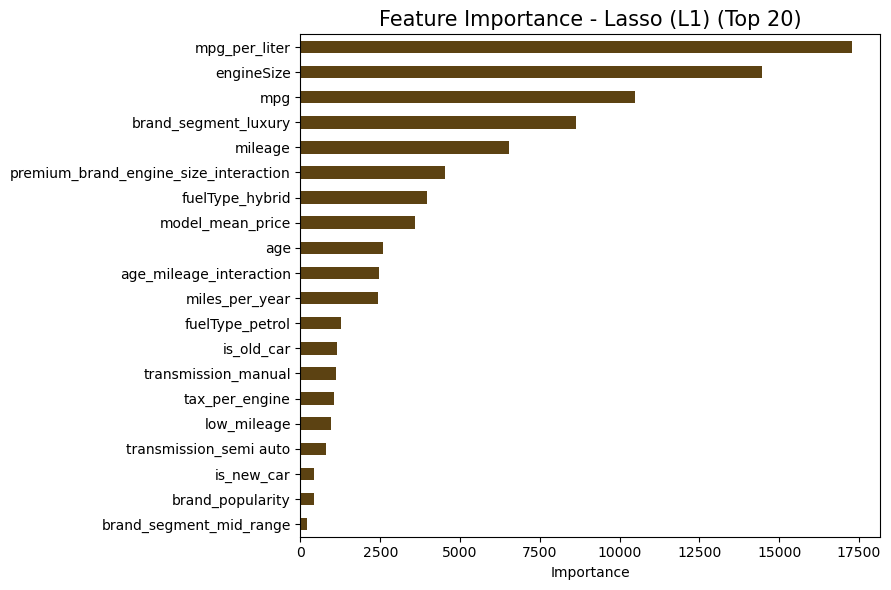


------------------------------------------------------------
MODEL: Lasso (L1)
Threshold: 3261.6052
Selected: 8 features
Features: ['mileage', 'mpg', 'engineSize', 'premium_brand_engine_size_interaction', 'mpg_per_liter', 'model_mean_price', 'fuelType_hybrid', 'brand_segment_luxury']
------------------------------------------------------------



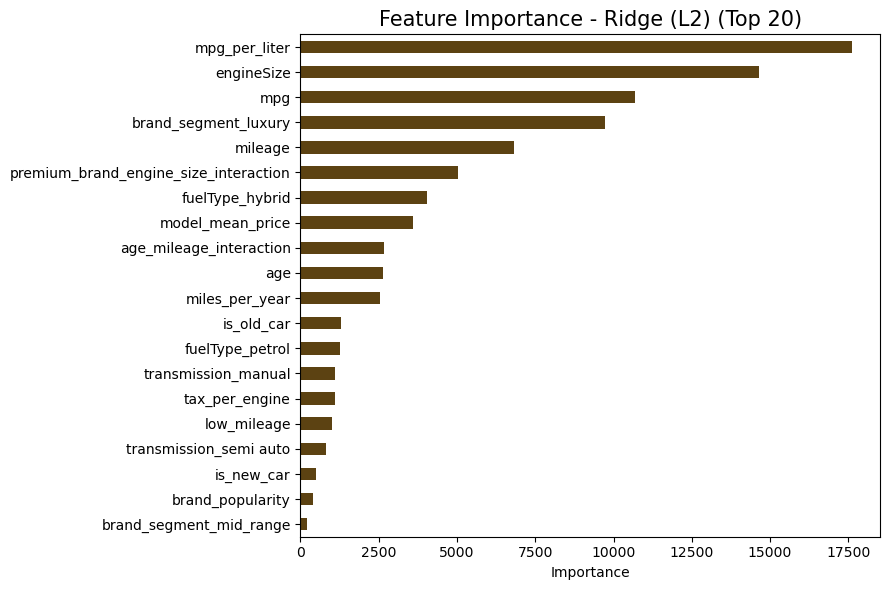


------------------------------------------------------------
MODEL: Ridge (L2)
Threshold: 3393.8180
Selected: 8 features
Features: ['mileage', 'mpg', 'engineSize', 'premium_brand_engine_size_interaction', 'mpg_per_liter', 'model_mean_price', 'fuelType_hybrid', 'brand_segment_luxury']
------------------------------------------------------------



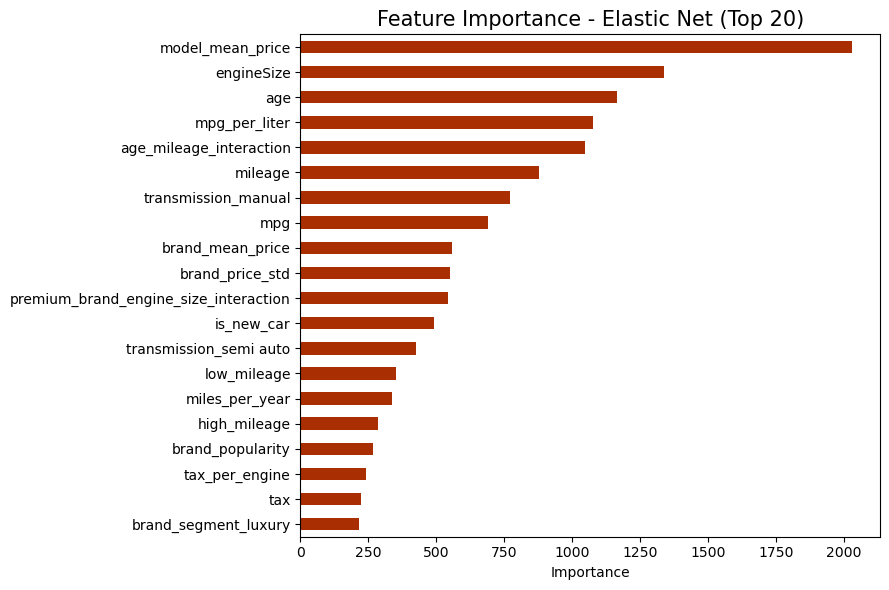


------------------------------------------------------------
MODEL: Elastic Net
Threshold: 544.4647
Selected: 10 features
Features: ['model_mean_price', 'engineSize', 'age', 'mpg_per_liter', 'age_mileage_interaction', 'mileage', 'transmission_manual', 'mpg', 'brand_mean_price', 'brand_price_std']
------------------------------------------------------------



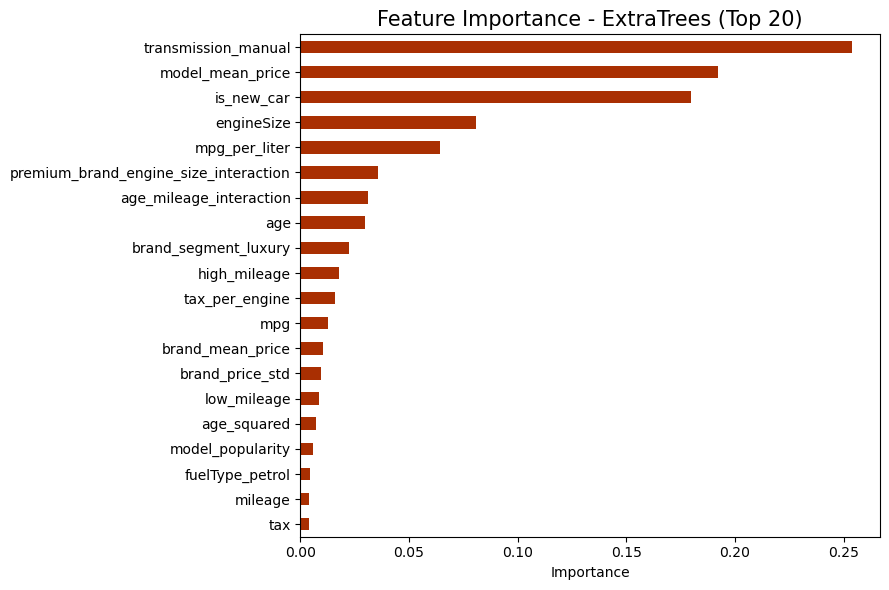


------------------------------------------------------------
MODEL: ExtraTrees
Threshold: 0.0385
Selected: 5 features
Features: ['transmission_manual', 'model_mean_price', 'is_new_car', 'engineSize', 'mpg_per_liter']
------------------------------------------------------------



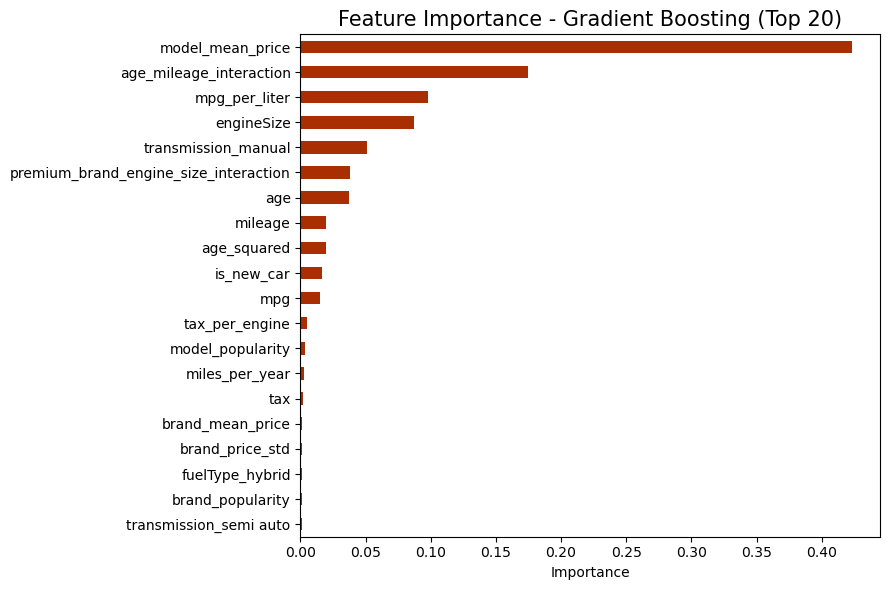


------------------------------------------------------------
MODEL: Gradient Boosting
Threshold: 0.0385
Selected: 5 features
Features: ['model_mean_price', 'age_mileage_interaction', 'mpg_per_liter', 'engineSize', 'transmission_manual']
------------------------------------------------------------



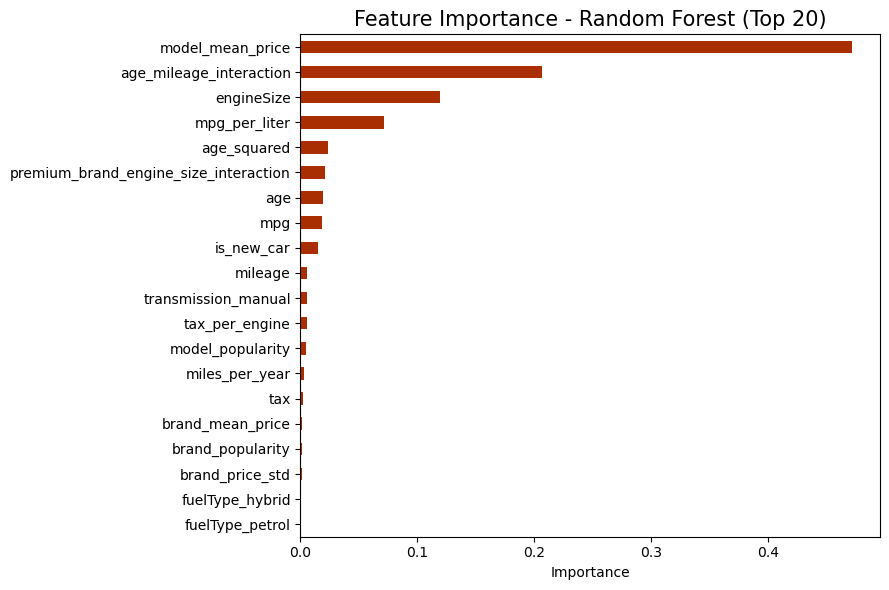


------------------------------------------------------------
MODEL: Random Forest
Threshold: 0.0385
Selected: 4 features
Features: ['model_mean_price', 'age_mileage_interaction', 'engineSize', 'mpg_per_liter']
------------------------------------------------------------



['model_mean_price', 'age_mileage_interaction', 'engineSize', 'mpg_per_liter']

In [15]:
# Plot feature importance
utils.plot_importance_unified(palette, abs(lasso_coefs), "Lasso (L1)", is_tree_model=False)
utils.print_selection_results(abs(lasso_coefs), "Lasso (L1)")

utils.plot_importance_unified(palette, abs(ridge_coefs), "Ridge (L2)", is_tree_model=False) 
utils.print_selection_results(abs(ridge_coefs), "Ridge (L2)")

utils.plot_importance_unified(palette, elasticnet_importance, "Elastic Net", is_tree_model=True)
utils.print_selection_results(elasticnet_importance, "Elastic Net")

utils.plot_importance_unified(palette, et_importance, "ExtraTrees", is_tree_model=True)
utils.print_selection_results(et_importance, "ExtraTrees")

utils.plot_importance_unified(palette, gb_importance, "Gradient Boosting", is_tree_model=True)
utils.print_selection_results(gb_importance, "Gradient Boosting")

utils.plot_importance_unified(palette, rf_importance, "Random Forest", is_tree_model=True)
utils.print_selection_results(rf_importance, "Random Forest")

### 2.3 Select Optimal Number of Features

We test different numbers of top features to find the optimal subset for each model.

In [19]:
# Create ranks for each model (1 = most important)
elasticnet_ranks = pd.Series(range(1, len(elasticnet_importance) + 1), index=elasticnet_importance.index)
et_ranks = pd.Series(range(1, len(et_importance) + 1), index=et_importance.index)
gb_ranks = pd.Series(range(1, len(gb_importance) + 1), index=gb_importance.index)
rf_ranks = pd.Series(range(1, len(rf_importance) + 1), index=rf_importance.index)

# Combine and sort
feature_ranks = (elasticnet_ranks + et_ranks + gb_ranks + rf_ranks).sort_values()

# Final sorted list
ranked_features = feature_ranks.index.tolist()
print(ranked_features)

# Model configurations
model_configs = {
    'ELASTICNET': lambda: ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=37, max_iter=10000),
    'ET': lambda: ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=37, n_jobs=-1),
    'GB': lambda: GradientBoostingRegressor(n_estimators=200, max_depth=7, learning_rate=0.06, random_state=37),
    'RF': lambda: RandomForestRegressor(n_estimators=100, max_depth=15, random_state=37, n_jobs=-1),
    'KNN': lambda: KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=-1)
}

# Initialize results with history for plotting
best_results = {name: {'best_n': None, 'best_mae': float('inf'), 'features': ranked_features,
                       'train_history': [], 'val_history': []} 
                for name in model_configs.keys()}

# Test from 3 to 20 features
feature_range = range(3, len(ranked_features))

print("="*70)
print("FEATURE SELECTION - TESTING OPTIMAL NUMBER")
print("="*70)

for n_features in feature_range:
    features = ranked_features[:n_features]
    
    for model_name, create_model in model_configs.items():
        model = create_model()
        model.fit(X_train_scaled[features], y_train_array)
        
        # Calculate both train and val MAE
        train_mae = mean_absolute_error(y_train_array, model.predict(X_train_scaled[features]))
        val_mae = mean_absolute_error(y_val_array, model.predict(X_val_scaled[features]))
        
        # Store history for plotting
        best_results[model_name]['train_history'].append(train_mae)
        best_results[model_name]['val_history'].append(val_mae)
        
        # Update if improved
        if val_mae < best_results[model_name]['best_mae']:
            best_results[model_name]['best_mae'] = val_mae
            best_results[model_name]['best_n'] = n_features

    # Show progress
    print(f"n={n_features:2d} | ElasticNet: {best_results['ELASTICNET']['val_history'][-1]:,.0f} | ExtraTrees: {best_results['ET']['val_history'][-1]:,.0f} | GB: {best_results['GB']['val_history'][-1]:,.0f} | RF: {best_results['RF']['val_history'][-1]:,.0f} | KNN: {best_results['KNN']['val_history'][-1]:,.0f}")


['model_mean_price', 'engineSize', 'mpg_per_liter', 'age_mileage_interaction', 'transmission_manual', 'age', 'premium_brand_engine_size_interaction', 'is_new_car', 'mpg', 'mileage', 'tax_per_engine', 'brand_mean_price', 'age_squared', 'brand_price_std', 'miles_per_year', 'model_popularity', 'tax', 'brand_popularity', 'brand_segment_luxury', 'high_mileage', 'low_mileage', 'transmission_semi auto', 'fuelType_hybrid', 'fuelType_petrol', 'brand_segment_mid_range', 'is_old_car']
FEATURE SELECTION - TESTING OPTIMAL NUMBER
n= 3 | ElasticNet: 4,615 | ExtraTrees: 3,487 | GB: 2,662 | RF: 2,258 | KNN: 2,277
n= 4 | ElasticNet: 3,197 | ExtraTrees: 1,914 | GB: 1,547 | RF: 1,468 | KNN: 1,581
n= 5 | ElasticNet: 3,102 | ExtraTrees: 1,845 | GB: 1,502 | RF: 1,438 | KNN: 1,541
n= 6 | ElasticNet: 2,981 | ExtraTrees: 1,785 | GB: 1,450 | RF: 1,389 | KNN: 1,515
n= 7 | ElasticNet: 2,957 | ExtraTrees: 1,753 | GB: 1,441 | RF: 1,382 | KNN: 1,494
n= 8 | ElasticNet: 2,955 | ExtraTrees: 1,767 | GB: 1,441 | RF: 1,382

Vamos focar-nos em escolher as variaveis com base nos dois melhores modelos

In [24]:
final_features = [
    'model_mean_price',
    'engineSize', 
    'mpg_per_liter', 
    'age_mileage_interaction', 
    'transmission_manual', 
    'age', 
    'premium_brand_engine_size_interaction', 
    #'is_new_car', 
    'mpg', 
    #'mileage', 
    'tax_per_engine',
    'brand_mean_price', 
    # 'age_squared', 
    'brand_price_std',
    # 'miles_per_year', 
    'model_popularity',
    # 'tax', 
    'brand_popularity', 
    # 'brand_segment_luxury',
    'high_mileage', 
    'low_mileage', 
    'transmission_semi auto', 
    'fuelType_hybrid', 
    'fuelType_petrol', 
    'brand_segment_mid_range', 
    'is_old_car'
]


final_features_sorted_rf = (
    rf_importance
    .loc[final_features]
    .sort_values(ascending=False)
    .index
    .tolist()
)

print(final_features_sorted_rf)

feature_range = range(1, len(final_features))

best_results ={}
# Initialize results with history for plotting
best_results = {name: {'best_n': None, 'best_mae': float('inf'), 'features': final_features_sorted_rf,
                       'train_history': [], 'val_history': []} 
                for name in model_configs.keys()}

print("="*70)
print("FEATURE SELECTION - TESTING OPTIMAL NUMBER")
print("="*70)

for n_features in feature_range:
    features = final_features_sorted_rf[:n_features]
    
    for model_name, create_model in model_configs.items():
        model = create_model()
        model.fit(X_train_scaled[features], y_train_array)
        
        # Calculate both train and val MAE
        train_mae = mean_absolute_error(y_train_array, model.predict(X_train_scaled[features]))
        val_mae = mean_absolute_error(y_val_array, model.predict(X_val_scaled[features]))
        
        # Store history for plotting
        best_results[model_name]['train_history'].append(train_mae)
        best_results[model_name]['val_history'].append(val_mae)
        
        # Update if improved
        if val_mae < best_results[model_name]['best_mae']:
            best_results[model_name]['best_mae'] = val_mae
            best_results[model_name]['best_n'] = n_features

 # Show progress
    print(f"n={n_features:2d} | ElasticNet: {best_results['ELASTICNET']['val_history'][-1]:,.0f} | ExtraTrees: {best_results['ET']['val_history'][-1]:,.0f} | GB: {best_results['GB']['val_history'][-1]:,.0f} | RF: {best_results['RF']['val_history'][-1]:,.0f} | KNN: {best_results['KNN']['val_history'][-1]:,.0f}")


['model_mean_price', 'age_mileage_interaction', 'engineSize', 'mpg_per_liter', 'premium_brand_engine_size_interaction', 'age', 'mpg', 'transmission_manual', 'tax_per_engine', 'model_popularity', 'brand_mean_price', 'brand_popularity', 'brand_price_std', 'fuelType_hybrid', 'fuelType_petrol', 'transmission_semi auto', 'brand_segment_mid_range', 'is_old_car', 'high_mileage', 'low_mileage']
FEATURE SELECTION - TESTING OPTIMAL NUMBER
n= 1 | ElasticNet: 4,780 | ExtraTrees: 4,369 | GB: 4,370 | RF: 4,369 | KNN: 4,480
n= 2 | ElasticNet: 3,499 | ExtraTrees: 2,451 | GB: 2,285 | RF: 2,313 | KNN: 2,355
n= 3 | ElasticNet: 3,184 | ExtraTrees: 2,003 | GB: 1,710 | RF: 1,713 | KNN: 1,782
n= 4 | ElasticNet: 3,197 | ExtraTrees: 1,915 | GB: 1,547 | RF: 1,468 | KNN: 1,581
n= 5 | ElasticNet: 3,151 | ExtraTrees: 1,872 | GB: 1,531 | RF: 1,459 | KNN: 1,558
n= 6 | ElasticNet: 3,026 | ExtraTrees: 1,819 | GB: 1,482 | RF: 1,409 | KNN: 1,523
n= 7 | ElasticNet: 3,032 | ExtraTrees: 1,794 | GB: 1,460 | RF: 1,396 | KNN:

Lets use 14


Plotting visuals...



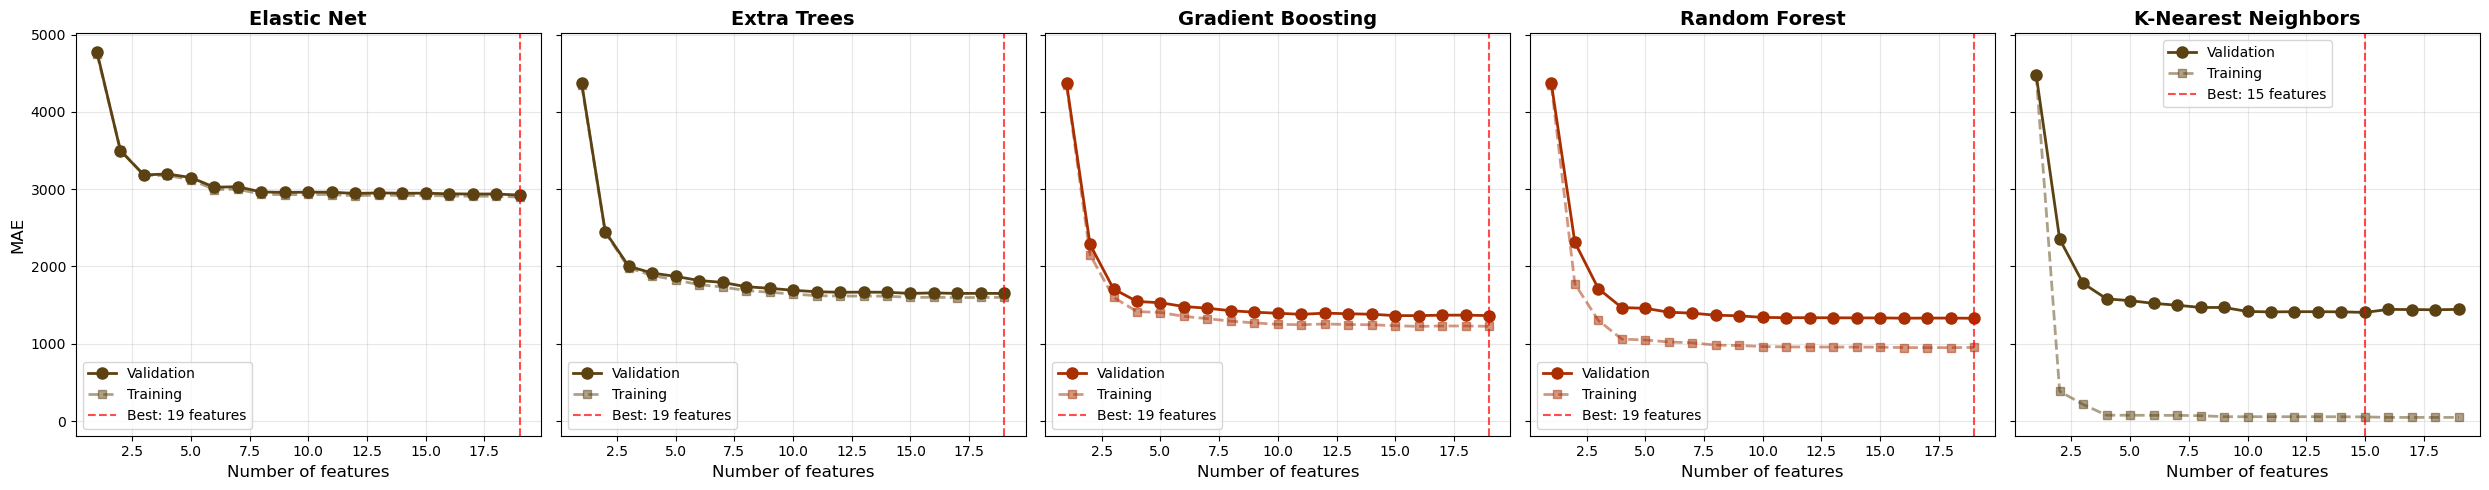

In [25]:
print("\nPlotting visuals...\n")

# X-axis: number of features tested
n_values = list(feature_range)

fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True)

# (chave_no_dict, título_para_o_gráfico, cor_base_index_palette)
plots_config = [
    ("ELASTICNET", "Elastic Net", 0),
    ("ET",         "Extra Trees", 0),
    ("GB",         "Gradient Boosting", 1),
    ("RF",         "Random Forest", 1),
    ("KNN",        "K-Nearest Neighbors", 0),
]

for ax, (model_key, title, color_idx) in zip(axes, plots_config):
    train_history = best_results[model_key]["train_history"]
    val_history = best_results[model_key]["val_history"]
    best_n = best_results[model_key]["best_n"]

    # Validation
    ax.plot(
        n_values, val_history,
        marker="o", linewidth=2, markersize=8,
        color=palette[color_idx], label="Validation"
    )

    # Training
    ax.plot(
        n_values, train_history,
        marker="s", linewidth=2, markersize=6,
        color=palette[color_idx], alpha=0.5,
        linestyle="--", label="Training"
    )

    # Best vertical line
    ax.axvline(
        best_n, color="red", linestyle="--", alpha=0.7,
        label=f"Best: {int(best_n)} features"
    )

    ax.set_xlabel("Number of features", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)

# Shared Y label (only once because sharey=True)
axes[0].set_ylabel("MAE", fontsize=12)

plt.tight_layout()
plt.show()


In [26]:
print(final_features_sorted_rf)

['model_mean_price', 'age_mileage_interaction', 'engineSize', 'mpg_per_liter', 'premium_brand_engine_size_interaction', 'age', 'mpg', 'transmission_manual', 'tax_per_engine', 'model_popularity', 'brand_mean_price', 'brand_popularity', 'brand_price_std', 'fuelType_hybrid', 'fuelType_petrol', 'transmission_semi auto', 'brand_segment_mid_range', 'is_old_car', 'high_mileage', 'low_mileage']


In [ ]:
selected_features = ['model_mean_price', 'model_popularity', 
                     'brand_mean_price', 'brand_popularity',
                     'engineSize','age', 'mpg', 
                     'premium_brand_engine_size_interaction', 
                     'age_mileage_interaction','mpg_per_liter', 
                     'tax_per_engine', 'transmission_manual',
                     'fuelType_hybrid', 'fuelType_petrol']

<a id='3-benchmarking'></a>
<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px rgba(227, 167, 108, 1);">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712ff;"><b>3 | Regression Benchmarking</b></span>
    </h1>
</div>

We use a **holdout validation strategy** (80/20 split) to evaluate models. The primary metric is **Mean Absolute Error (MAE)** as it directly represents the average prediction error in pounds.

### 3.1 Evaluation Function

In [ ]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    """Calculate train and validation metrics"""
    y_train_pred = np.expm1(model.predict(X_train))
    y_val_pred = np.expm1(model.predict(X_val))
    
    scores = {
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Train RMSE': root_mean_squared_error(y_train, y_train_pred),
        'Val RMSE': root_mean_squared_error(y_val, y_val_pred),
        'Train Pinball (α=0.5)': mean_pinball_loss(y_train, y_train_pred, alpha=0.5),
        'Val Pinball (α=0.5)': mean_pinball_loss(y_val, y_val_pred, alpha=0.5)
    }
    return scores

### 3.2 Hyperparameter Grid Search

In [ ]:
# Define model configurations with hyperparameter grids
# Using model-specific feature subsets and scaling
models_and_grids = {
    "Elastic Net": {
        "model": ElasticNet(random_state=37, max_iter=10000),
        "params": {
            'alpha': [0.8731, 0.8732, 0.8733, 0.8734, 0.8735, 0.8736, 0.8737, 0.8738, 0.8739], 
            'l1_ratio': [0.91]
        } 
    },
    "KNeighbors": {
        "model": KNeighborsRegressor(n_jobs=-1),
        "params": {
            'n_neighbors': [8, 20, 25, 30],
            'weights': ['distance'],
            'p': [1, 2]
        }
    },
    "Extra Tree": {
        "model": ExtraTreesRegressor(random_state=37, n_jobs=-1),
        "params": {
            'n_estimators': [240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250],
            'max_depth': [16, 18, 22],
            'min_samples_leaf': [2, 4, 6],
            'max_features': ['sqrt', 0.6, None]
        }
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=37, n_jobs=-1),
        "params": {
            'n_estimators': [450, 460, 470, 480, 490, 500],
            'max_depth': [14, 16, 19, 20],
            'min_samples_leaf': [1, 2, 3, 4, 6],
            'max_features': ['log2', 'sqrt']
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=37),
        "params": {
            'learning_rate': [0.01, 0.02],
            'max_depth': [7, 8, 9, 11],
            'min_samples_leaf': [2, 4, 6],
            'n_estimators': [970, 980, 990, 1000],
            'subsample': [0.7, 0.75],
            'max_features': ['sqrt']  
        }
    }
}


In [ ]:
# Run grid search for each model
results_list = []

for model_name, config in models_and_grids.items():
    print(f"\n{'='*70}")
    print(f"Grid Search: {model_name}")
    print(f"{'='*70}")
    
    X_tr = X_train_scaled[selected_features]
    X_vl = X_val_scaled[selected_features]
    
    param_grid = ParameterGrid(config['params'])
    best_val_mae = float('inf')
    best_result = None
    
    for i, params in enumerate(param_grid):
        model = clone(config['model'])
        model.set_params(**params)
        model.fit(X_tr, y_train_log)
        
        scores = evaluate_model(model, X_tr, y_train, X_vl, y_val)
        
        if scores['Val MAE'] < best_val_mae:
            best_val_mae = scores['Val MAE']
            best_result = {
                'Model': model_name,
                'Best Params': str(params),
                **scores
            }
            print(f"   New best: {params} - VAL MAE:{scores['Val MAE']:,.2f}")
    
    results_list.append(best_result)
    print(f"\n Best {model_name} VAL MAE: {best_val_mae:,.2f}")

# Create results DataFrame
results_df = pd.DataFrame(results_list).sort_values('Val MAE')
print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)
display(results_df[['Model', 'Val MAE', 'Train MAE', 'Val RMSE', 'Best Params']])


Grid Search: Elastic Net
   New best: {'alpha': 0.8731, 'l1_ratio': 0.91} - VAL MAE:£2,726.65
   New best: {'alpha': 0.8732, 'l1_ratio': 0.91} - VAL MAE:£2,726.65
   New best: {'alpha': 0.8733, 'l1_ratio': 0.91} - VAL MAE:£2,726.65
   New best: {'alpha': 0.8734, 'l1_ratio': 0.91} - VAL MAE:£2,726.65
   New best: {'alpha': 0.8735, 'l1_ratio': 0.91} - VAL MAE:£2,726.65
   New best: {'alpha': 0.8736, 'l1_ratio': 0.91} - VAL MAE:£2,726.65
   New best: {'alpha': 0.8737, 'l1_ratio': 0.91} - VAL MAE:£2,726.65

 Best Elastic Net VAL MAE: £2,726.65

Grid Search: KNeighbors
   New best: {'n_neighbors': 8, 'p': 1, 'weights': 'distance'} - VAL MAE:£1,359.22

 Best KNeighbors VAL MAE: £1,359.22

Grid Search: Extra Tree
   New best: {'max_depth': 22, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 240} - VAL MAE:£1,247.71

 Best Extra Tree VAL MAE: £1,247.71

Grid Search: RandomForest
   New best: {'max_depth': 19, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 450} - V

,Model,Val MAE,Train MAE,Val RMSE,Best Params
4,GradientBoosting,1211.110840,660.849724,2027.954143,"{'learning_rate': 0.02, 'max_depth': 11, 'min_..."
2,Extra Tree,1247.709147,703.960630,2089.795890,"{'max_depth': 22, 'max_features': None, 'min_s..."
3,RandomForest,1248.143029,691.954700,2098.885705,"{'max_depth': 19, 'max_features': 'log2', 'min..."
1,KNeighbors,1359.219239,18.061026,2335.371508,"{'n_neighbors': 8, 'p': 1, 'weights': 'distance'}"
0,Elastic Net,2726.654836,2721.675448,4475.188313,"{'alpha': 0.8737, 'l1_ratio': 0.91}"


<a id='4-optimization'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>4 | Model Optimization - Ensemble</b></span>
    </h1>
</div>

We use **Stacking** to combine our three best models (GB, RF, KNN). Stacking trains a meta-learner (Ridge regression) on the predictions of base models, learning optimal combination weights automatically via cross-validation.

Additionally, we apply **log transformation** to the target variable, which reduces the impact of price outliers and typically improves MAE in price prediction tasks.

### 4.1 Extract Best Parameters

In [ ]:
# Extract best hyperparameters
best_params = {}
for model_name in results_df['Model'].unique():
    params_str = results_df[results_df['Model'] == model_name]['Best Params'].values[0]
    best_params[model_name] = eval(params_str)
    print(f"{model_name}: {best_params[model_name]}")

GradientBoosting: {'learning_rate': 0.02, 'max_depth': 11, 'min_samples_leaf': 2, 'n_estimators': 980, 'subsample': 0.7}
Extra Tree: {'max_depth': 22, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 240}
RandomForest: {'max_depth': 19, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 460}
KNeighbors: {'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
Elastic Net: {'alpha': 0.8737, 'l1_ratio': 0.91}


### 4.2 Train Weighted Ensemble Model

In [ ]:
# Train all 5 models
print("Training 5 models...", end=" ", flush=True)

gb_model = GradientBoostingRegressor(**best_params['GradientBoosting'], random_state=37)
gb_model.fit(X_train_scaled[selected_features], y_train_log)

rf_model = RandomForestRegressor(**best_params['RandomForest'], random_state=37, n_jobs=-1)
rf_model.fit(X_train_scaled[selected_features], y_train_log)

et_model = ExtraTreesRegressor(**best_params['Extra Tree'], random_state=37, n_jobs=-1)
et_model.fit(X_train_scaled[selected_features], y_train_log)

knn_model = KNeighborsRegressor(**best_params['KNeighbors'], n_jobs=-1)
knn_model.fit(X_train_scaled[selected_features], y_train_log)

en_model = ElasticNet(**best_params['Elastic Net'])
en_model.fit(X_train_scaled[selected_features], y_train_log)


# Get predictions from all models
print("Computing predictions...", end=" ", flush=True)

# Train predictions
gb_train_pred = gb_model.predict(X_train_scaled[selected_features])
rf_train_pred = rf_model.predict(X_train_scaled[selected_features])
et_train_pred = et_model.predict(X_train_scaled[selected_features])
knn_train_pred = knn_model.predict(X_train_scaled[selected_features])
en_train_pred = en_model.predict(X_train_scaled[selected_features])

# Validation predictions
gb_val_pred = gb_model.predict(X_val_scaled[selected_features])
rf_val_pred = rf_model.predict(X_val_scaled[selected_features])
et_val_pred = et_model.predict(X_val_scaled[selected_features])
knn_val_pred = knn_model.predict(X_val_scaled[selected_features])
en_val_pred = en_model.predict(X_val_scaled[selected_features])


# Evaluate individual models
print("\n" + "="*70)
print("Individual Model Performance (with log transform)")
print("="*70)

models_preds = {
    'GradientBoosting': (gb_val_pred, gb_train_pred),
    'RandomForest': (rf_val_pred, rf_train_pred),
    'ExtraTrees': (et_val_pred, et_train_pred),
    'KNeighbors': (knn_val_pred, knn_train_pred),
    'ElasticNet': (en_val_pred, en_train_pred)
}

for name, (val_pred, train_pred) in models_preds.items():
    val_mae = mean_absolute_error(y_val_array, np.expm1(val_pred))
    train_mae = mean_absolute_error(y_train_array, np.expm1(train_pred))
    print(f"{name:20s} | Train MAE: {train_mae:,.2f} | Val MAE: {val_mae:,.2f}")

Training 5 models... Computing predictions... 
Individual Model Performance (with log transform)
GradientBoosting     | Train MAE: 694.05 | Val MAE: 1,196.08
RandomForest         | Train MAE: 699.38 | Val MAE: 1,236.99
ExtraTrees           | Train MAE: 705.97 | Val MAE: 1,239.30
KNeighbors           | Train MAE: 18.04 | Val MAE: 1,348.90
ElasticNet           | Train MAE: 6,799.64 | Val MAE: 6,809.95


ElasticNet piora muito com log, nao faz mal, vai ser ignorado nas cenas

In [ ]:
# Define objective function for weight optimization
def ensemble_mae(weights, predictions_train, predictions_val, y_train, y_val):
    """Calculate validation MAE for weighted ensemble"""
    # Ensure weights sum to 1
    weights = np.array(weights) / np.sum(weights)
    
    # Weighted combination
    val_pred_log = sum(w * p for w, p in zip(weights, predictions_val))
    val_pred = np.expm1(val_pred_log)
    
    return mean_absolute_error(y_val, val_pred)

# Prepare predictions lists
train_preds = [gb_train_pred, rf_train_pred, et_train_pred, knn_train_pred, en_train_pred]
val_preds = [gb_val_pred, rf_val_pred, et_val_pred, knn_val_pred, en_val_pred]

# Initial weights (equal)
initial_weights = [0.2, 0.2, 0.2, 0.2, 0.2]

# Bounds (each weight between 0 and 1)
bounds = [(0.0, 1.0) for _ in range(5)]

# Constraint: weights must sum to 1
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

# Optimize weights
print("Optimizing weights...", end=" ", flush=True)
result = minimize(
    ensemble_mae,
    initial_weights,
    args=(train_preds, val_preds, y_train_array, y_val_array),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'maxiter': 1000}
)

# Extract optimized weights
best_weights = result.x / np.sum(result.x)  # Normalize to sum to 1
w_gb, w_rf, w_et, w_knn, w_en = best_weights

# Calculate final ensemble MAE
ensemble_val_pred_log = (w_gb * gb_val_pred + w_rf * rf_val_pred + 
                         w_et * et_val_pred + w_knn * knn_val_pred + 
                         w_en * en_val_pred)
ensemble_val_pred = np.expm1(ensemble_val_pred_log)
ensemble_val_mae = mean_absolute_error(y_val_array, ensemble_val_pred)

ensemble_train_pred_log = (w_gb * gb_train_pred + w_rf * rf_train_pred + 
                           w_et * et_train_pred + w_knn * knn_train_pred + 
                           w_en * en_train_pred)
ensemble_train_pred = np.expm1(ensemble_train_pred_log)
ensemble_train_mae = mean_absolute_error(y_train_array, ensemble_train_pred)

print("\n" + "="*70)
print("WEIGHTED ENSEMBLE RESULTS")
print("="*70)
print(f"\nOptimal Weights:")
print(f"\n Weighted Ensemble TRAIN MAE: {ensemble_train_mae:,.2f}")
print(f" Weighted Ensemble VAL MAE: {ensemble_val_mae:,.2f}")

Optimizing weights... 
WEIGHTED ENSEMBLE RESULTS

Optimal Weights:

 Weighted Ensemble TRAIN MAE: 678.65
 Weighted Ensemble VAL MAE: 1,191.03


### 4.3 Train Stacking Model

In [ ]:
# Create stacking model with 5 base estimators
stacking_model = StackingRegressor(
    estimators=[
        ('gb', GradientBoostingRegressor(**best_params['GradientBoosting'], random_state=37)),
        ('rf', RandomForestRegressor(**best_params['RandomForest'], random_state=37, n_jobs=-1)),
        ('et', ExtraTreesRegressor(**best_params['Extra Tree'], random_state=37, n_jobs=-1)),
        ('knn', KNeighborsRegressor(**best_params['KNeighbors'], n_jobs=-1)),
        ('en', ElasticNet(**best_params['Elastic Net']))
    ],
    final_estimator=Ridge(alpha=10.0),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Train with LOG-transformed target
print("Training stacking model with 5 base models...", end=" ", flush=True)
stacking_model.fit(X_train_scaled[selected_features], y_train_log)

# Evaluate on train (convert predictions back to original scale)
stacking_train_pred_log = stacking_model.predict(X_train_scaled[selected_features])
stacking_train_pred = np.expm1(stacking_train_pred_log)
stacking_train_mae = mean_absolute_error(y_train_array, stacking_train_pred)

# Evaluate on validation (convert predictions back to original scale)
stacking_val_pred_log = stacking_model.predict(X_val_scaled[selected_features])
stacking_val_pred = np.expm1(stacking_val_pred_log)
stacking_val_mae = mean_absolute_error(y_val_array, stacking_val_pred)

print("\n" + "="*70)
print("STACKING ENSEMBLE RESULTS")
print("="*70)
print(f"\nStacking TRAIN MAE: {stacking_train_mae:,.2f}")
print(f"Stacking VAL MAE: {stacking_val_mae:,.2f}")

Training stacking model with 5 base models... 
STACKING ENSEMBLE RESULTS

Stacking TRAIN MAE: 605.06
Stacking VAL MAE: 1,195.42


<a id='5-deployment'></a>
<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px rgba(227, 167, 108, 1);">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712ff;"><b>5 | Deployment - Final Submission</b></span>
    </h1>
</div>

Retrain the stacking model on the full dataset (train + validation) and generate predictions for the test set.

In [ ]:
# Train all 5 models on full dataset
print("\nTraining final models on full dataset...")

print("\n   GradientBoosting...", end=" ", flush=True)
gb_final = GradientBoostingRegressor(**best_params['GradientBoosting'], random_state=37)
gb_final.fit(X_train_full_scaled[selected_features], y_train_full_log)

print("\n   RandomForest...", end=" ", flush=True)
rf_final = RandomForestRegressor(**best_params['RandomForest'], random_state=37, n_jobs=-1)
rf_final.fit(X_train_full_scaled[selected_features], y_train_full_log)

print("\n   ExtraTrees...", end=" ", flush=True)
et_final = ExtraTreesRegressor(**best_params['Extra Tree'], random_state=37, n_jobs=-1)
et_final.fit(X_train_full_scaled[selected_features], y_train_full_log)

print("\n   KNeighbors...", end=" ", flush=True)
knn_final = KNeighborsRegressor(**best_params['KNeighbors'], n_jobs=-1)
knn_final.fit(X_train_full_scaled[selected_features], y_train_full_log)

print("\n   ElasticNet...", end=" ", flush=True)
en_final = ElasticNet(**best_params['Elastic Net'])
en_final.fit(X_train_full_scaled[selected_features], y_train_full_log)

# Calculate training MAE for weighted ensemble
ensemble_full_pred = np.expm1(
    w_gb * gb_final.predict(X_train_full_scaled[selected_features]) + 
    w_rf * rf_final.predict(X_train_full_scaled[selected_features]) + 
    w_et * et_final.predict(X_train_full_scaled[selected_features]) + 
    w_knn * knn_final.predict(X_train_full_scaled[selected_features]) + 
    w_en * en_final.predict(X_train_full_scaled[selected_features])
)
weighted_full_mae = mean_absolute_error(y_train_full_array, ensemble_full_pred)
print(f"\nWeighted Ensemble Full Training MAE: {weighted_full_mae:,.2f}")

# Train Stacking Ensemble on full data
print("\nTraining Stacking Ensemble on full dataset...", end=" ", flush=True)
stacking_final = StackingRegressor(
    estimators=[
        ('gb', GradientBoostingRegressor(**best_params['GradientBoosting'], random_state=37)),
        ('rf', RandomForestRegressor(**best_params['RandomForest'], random_state=37, n_jobs=-1)),
        ('et', ExtraTreesRegressor(**best_params['Extra Tree'], random_state=37, n_jobs=-1)),
        ('knn', KNeighborsRegressor(**best_params['KNeighbors'], n_jobs=-1)),
        ('en', ElasticNet(**best_params['Elastic Net']))
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1
)
stacking_final.fit(X_train_full_scaled[selected_features], y_train_full_log)

stacking_full_mae = mean_absolute_error(y_train_full_array, np.expm1(stacking_final.predict(X_train_full_scaled[selected_features])))
print(f"Stacking Ensemble Full Training MAE: {stacking_full_mae:,.2f}")


Training final models on full dataset...

   GradientBoosting... 
   RandomForest... 
   ExtraTrees... 
   KNeighbors... 
   ElasticNet... 
Weighted Ensemble Full Training MAE: 718.38

Training Stacking Ensemble on full dataset... Stacking Ensemble Full Training MAE: 649.43


In [ ]:
# Generate predictions for test set
print("\nGenerating test predictions...")

# Weighted Ensemble predictions
weighted_pred = np.expm1(
    w_gb * gb_final.predict(X_test_scaled[selected_features]) + 
    w_rf * rf_final.predict(X_test_scaled[selected_features]) + 
    w_et * et_final.predict(X_test_scaled[selected_features]) + 
    w_knn * knn_final.predict(X_test_scaled[selected_features]) + 
    w_en * en_final.predict(X_test_scaled[selected_features])
)

# Stacking Ensemble predictions
stacking_pred = np.expm1(stacking_final.predict(X_test_scaled[selected_features]))

# Create submission DataFrames
weighted_df = pd.DataFrame({
    'carID': X_test_scaled.index, 
    'price': weighted_pred
})

stacking_df = pd.DataFrame({
    'carID': X_test_scaled.index, 
    'price': stacking_pred
})

# Save submissions
weighted_df.to_csv("./project_data/Group37_Weighted_5models.csv", index=False)
stacking_df.to_csv("./project_data/Group37_Stacking_5models.csv", index=False)

# Print summary
print("\n" + "="*70)
print("SUBMISSION FILES GENERATED")
print("="*70)

print(f"\nWeighted Ensemble: Group37_Weighted_5models.csv")
print(f"   Weights: GB={w_gb:.3f} | RF={w_rf:.3f} | ET={w_et:.3f} | KNN={w_knn:.3f} | EN={w_en:.3f}")


print(f"\nStacking Ensemble: Group37_Stacking_5models.csv")



Generating test predictions...

SUBMISSION FILES GENERATED

Weighted Ensemble: Group37_Weighted_5models.csv
   Weights: GB=0.789 | RF=0.000 | ET=0.192 | KNN=0.016 | EN=0.002

Stacking Ensemble: Group37_Stacking_5models.csv


---
## Summary

**Final Models:** 5-model ensemble combining:
1. **GradientBoosting** - Best individual model
2. **RandomForest** - Strong tree-based ensemble
3. **ExtraTrees** - Randomized tree ensemble
4. **KNeighbors** - Instance-based learner
5. **ElasticNet** - Linear regularized model

**Ensemble Methods:**
- **Weighted Average**: Optimized weights via scipy.optimize
- **Stacking**: Ridge meta-learner with 5-fold CV

**Key Optimizations:**
1. Model-specific feature selection based on importance rankings
2. Log transformation of target to reduce outlier impact
3. 5-fold cross-validation for stacking
4. Weight optimization using SLSQP algorithm

---